In [2]:
from matplotlib import pyplot as plt
import fastf1
from fastf1 import utils
import pandas as pd
import numpy as np
from fastf1 import plotting

# Qualifying Lap comparison

In [3]:
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme='fastf1')

session = fastf1.get_session(2025, 'Japan', 'Q')

session.load()
fast_verstappen = session.laps.pick_drivers('VER').pick_fastest()
fast_norris = session.laps.pick_drivers('NOR').pick_fastest()


req         WARNING 	DEFAULT CACHE ENABLED! (771.25 MB) /home/vinicius/.cache/fastf1
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '12', '6', '44', '23', '87', '10', '55', '14', '30', '22', '27', '5', '31', '7', '18']


In [4]:
car_mv = fast_verstappen.get_car_data().add_distance()
car_ln = fast_norris.get_car_data().add_distance()


In [5]:
rbr_color = fastf1.plotting.get_team_color(fast_verstappen['Team'], session=session)
mcl_color = fastf1.plotting.get_team_color(fast_norris['Team'], session=session)

req            INFO 	Using cached data for driver_info


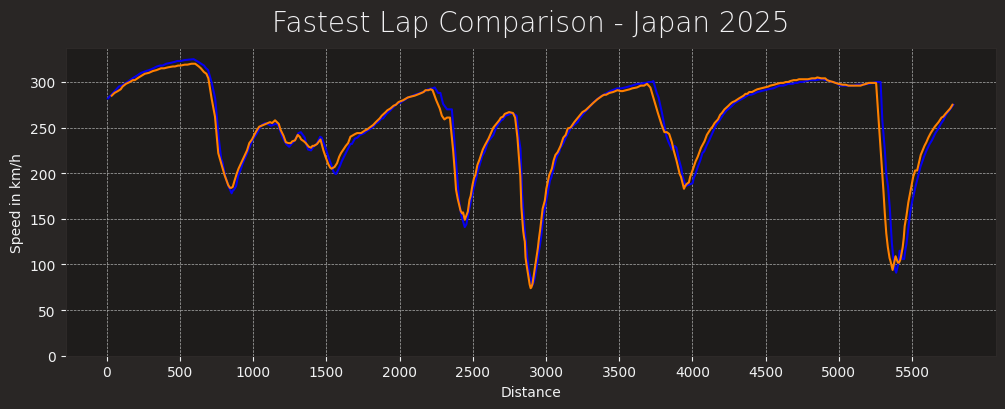

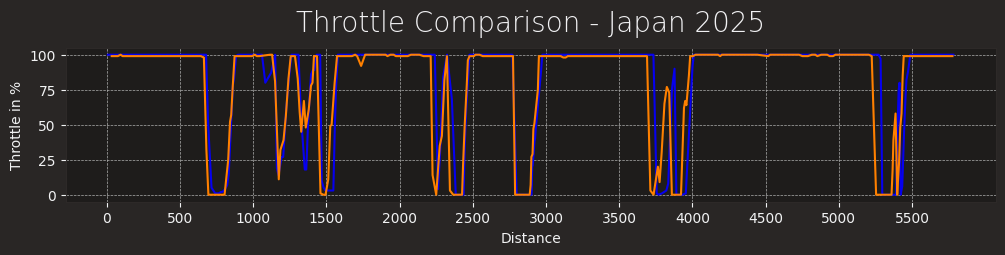

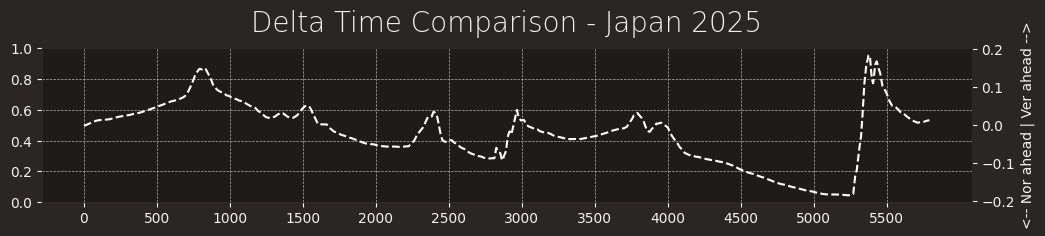

In [6]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
ax.set_title('Fastest Lap Comparison - Japan 2025', fontsize=20)

ax.plot(car_mv['Distance'], car_mv['Speed'], color=rbr_color, label='VER')
ax.plot(car_ln['Distance'], car_ln['Speed'], color=mcl_color, label='NOR')  

ax.set_xlabel('Distance')
ax.set_ylabel('Speed in km/h')

ax.set_xticks(np.arange(0, car_mv['Distance'].max(), 500))  # Intervalos no eixo X
ax.set_yticks(np.arange(0, max(car_mv['Speed'].max(), car_ln['Speed'].max()), 50)) # Intervalos no eixo Y
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

fig, ax = plt.subplots(figsize=(12, 2), dpi=100)
ax.set_title('Throttle Comparison - Japan 2025', fontsize=20)
ax.plot(car_mv['Distance'], car_mv['Throttle'], color=rbr_color, label='VER')
ax.plot(car_ln['Distance'], car_ln['Throttle'], color=mcl_color, label='NOR')
ax.set_xticks(np.arange(0, car_mv['Distance'].max(), 500))  # Intervalos no eixo X

ax.set_xlabel('Distance')
ax.set_ylabel('Throttle in %')

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

delta_time, ref_tel, compare_tel = utils.delta_time(fast_verstappen, fast_norris)
# Verstappen is the reference driver, Norris is the comparison driver

fig, ax = plt.subplots(figsize=(12, 2), dpi=100)
ax.set_title('Delta Time Comparison - Japan 2025', fontsize=20)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xticks(np.arange(0, car_mv['Distance'].max(), 500))  # Intervalos no eixo X

twin = ax.twinx()
twin.plot(ref_tel['Distance'], delta_time, '--', color='white')
twin.set_ylabel("<-- Nor ahead | Ver ahead -->")

plt.show()


### • Based on this analysis, it' possible to conclude that even though the cars were running with similar downforce specs. 
### • The RedBull is still likely to have some balance issues. In turns 4, 5, and 6 (around Distance 1000–1500), the RB21 has to lift off the throttle much more than the MCL39. 
### • Verstappen gained the most time in the last chicane, braking considerably later than Norris and everyone else, which secured him pole position 

# Race Pace Comparison

In [7]:
Race = fastf1.get_session(2025, 'Japan', 'R')

Race.load()
pace_ver = Race.laps.pick_drivers('VER').pick_quicklaps()
pace_nor = Race.laps.pick_drivers('NOR').pick_quicklaps()
pace_pia = Race.laps.pick_drivers('PIA').pick_quicklaps()

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '12', '44', '6', '23', '87', '14', '22', '10', '55', '7', '27', '30', '31', '5', '18']


In [8]:
pace_ver['LapTime'] = pace_ver['LapTime'].dt.total_seconds()
pace_nor['LapTime'] = pace_nor['LapTime'].dt.total_seconds()
pace_pia['LapTime'] = pace_pia['LapTime'].dt.total_seconds()

### • 10KG of added weight is about 0.3s in lap time. By dividing the maximum starting fuel (110kg) by the total of laps of the Grand Prix (53 for the Japanese Grand Prix), we have the car's average fuel consumption
### • That is the simplest way (and more effective way) to correct the laptimes without insider informations 

In [9]:
combustivel_inicial = 110
voltas = 53
consumo_medio = combustivel_inicial / voltas
dez_kg = 0.3

tempo_real_ver = pace_ver['LapTime']
tempo_real_nor = pace_nor['LapTime']
tempo_real_pia = pace_pia['LapTime']

tempos_ver_neutralizados = []
temos_nor_neutralizados = []
tempos_pia_neutralizados = []

for volta, tempo_real_ver in enumerate(tempo_real_ver, start=1):
    combustivel_atual = combustivel_inicial - (volta * consumo_medio)
    ajuste = (combustivel_atual / 10) * dez_kg
    tempo_neutralizado = tempo_real_ver - ajuste
    tempos_ver_neutralizados.append(tempo_neutralizado)
    
for volta, tempo_real_nor in enumerate(tempo_real_nor, start=1):
    combustivel_atual = combustivel_inicial - (volta * consumo_medio)
    ajuste = (combustivel_atual / 10) * dez_kg
    tempo_neutralizado = tempo_real_nor - ajuste
    temos_nor_neutralizados.append(tempo_neutralizado)

for volta, tempo_real_pia in enumerate(pace_pia['LapTime'], start=1):
    combustivel_atual = combustivel_inicial - (volta * consumo_medio)
    ajuste = (combustivel_atual / 10) * dez_kg
    tempo_neutralizado = tempo_real_pia - ajuste
    tempos_pia_neutralizados.append(tempo_neutralizado)


pace_ver['LapTime'] = tempos_ver_neutralizados
pace_nor['LapTime'] = temos_nor_neutralizados
pace_pia['LapTime'] = tempos_pia_neutralizados

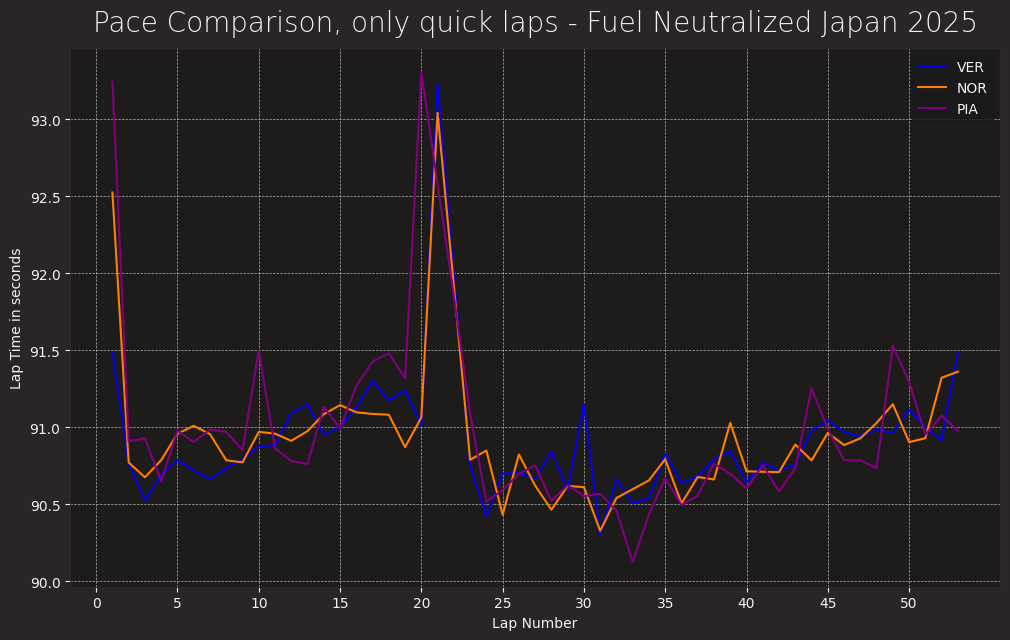

In [10]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)
ax.set_title('Pace Comparison, only quick laps - Fuel Neutralized Japan 2025', fontsize=20)

ax.plot(pace_ver['LapNumber'], pace_ver['LapTime'], color=rbr_color, label='VER')
ax.plot(pace_nor['LapNumber'], pace_nor['LapTime'], color=mcl_color, label='NOR')
ax.plot(pace_pia['LapNumber'], pace_pia['LapTime'], color='purple', label='PIA')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax.set_xticks(np.arange(0, pace_ver['LapNumber'].max(), 5))  # Intervalos no eixo X

ax.set_xlabel('Lap Number')
ax.set_ylabel('Lap Time in seconds')
ax.legend()

plt.show()


In [11]:
media_ver = pace_ver['LapTime'].mean()
media_nor = pace_nor['LapTime'].mean()
media_pia = pace_pia['LapTime'].mean()
print(f"Media VER: {media_ver:.3f}")
print(f"Media NOR: {media_nor:.3f}")
print(f"Media PIA: {media_pia:.3f}")
print(f"Delta Ver - Pia: {media_ver - media_pia:.3f}")
print(f"Delta Ver - Nor: {media_ver - media_nor:.3f}")
print(f"Delta Nor - Pia: {media_nor - media_pia:.3f}")

Media VER: 90.906
Media NOR: 90.919
Media PIA: 90.967
Delta Ver - Pia: -0.061
Delta Ver - Nor: -0.014
Delta Nor - Pia: -0.047


### • Although Verstappen's pace was only 0.014 faster than Norris's, the British driver was unable to overtake him, likely due to the car's instability in dirty air.
### • Piastri, who also had a similar pace to Norris was also unable to overtake him